In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import sqlite3
import palpy
import numbers


In [2]:
# Bunch of coord conversion stuff broken out of sims.utils 
def smallest_signed_angle(a1, a2):
    """
    via https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles"""
    TwoPi = 2.*np.pi
    x = a1 % TwoPi
    y = a2 % TwoPi
    a = (x - y) % TwoPi
    b = (y - x) % TwoPi
    result = b+0
    alb = np.where(a < b)[0]
    result[alb] = -1.*a[alb]
    return result

def equationOfEquinoxes(d):
    """
    The equation of equinoxes. See http://aa.usno.navy.mil/faq/docs/GAST.php

    @param [in] d is either a numpy array or a number that is Terrestrial Time
    expressed as an MJD

    @param [out] the equation of equinoxes in radians.
    """

    if isinstance(d, np.ndarray):
        return palpy.eqeqxVector(d)
    else:
        return palpy.eqeqx(d)

def calcLmstLast(mjd, longRad):
    """
    calculates local mean sidereal time and local apparent sidereal time

    @param [in] mjd is the universal time (UT1) expressed as an MJD.
    This can be a numpy array or a single value.

    @param [in] longRad is the longitude in radians (positive east of the prime meridian)
    This can be numpy array or a single value.  If a numpy array, should have the same length as mjd.  In that
    case, each longRad will be applied only to the corresponding mjd.

    @param [out] lmst is the local mean sidereal time in hours

    @param [out] last is the local apparent sideral time in hours
    """
    mjdIsArray = False
    longRadIsArray = False
    if isinstance(mjd, np.ndarray):
        mjdIsArray = True

    if isinstance(longRad, np.ndarray):
        longRadIsArray = True

    if longRadIsArray and mjdIsArray:
        if len(longRad) != len(mjd):
            raise RuntimeError("In calcLmstLast mjd and longRad have different lengths")

    valid_type = False
    if isinstance(mjd, np.ndarray) and isinstance(longRad, np.ndarray):
        valid_type = True
    elif isinstance(mjd, np.ndarray) and isinstance(longRad, numbers.Number):
        valid_type = True
    elif isinstance(mjd, numbers.Number) and isinstance(longRad, numbers.Number):
        valid_type = True

    if not valid_type:
        msg = "Valid input types for calcLmstLast are:\n" \
              "mjd and longRad as numpy arrays of the same length\n" \
              "mjd as a numpy array and longRad as a number\n" \
              "mjd as a number and longRad as a number\n" \
              "You gave mjd: %s\n" % type(mjd) \
              + "and longRad: %s\n" % type(longRad)

        raise RuntimeError(msg)

    longDeg0 = np.degrees(longRad)
    longDeg0 %= 360.0

    if longRadIsArray:
        longDeg = np.where(longDeg0 > 180.0, longDeg0 - 360.0, longDeg0)
    else:
        if longDeg0 > 180.:
            longDeg = longDeg0 - 360.
        else:
            longDeg = longDeg0

    hrs = longDeg / 15.0
    gmstgast = calcGmstGast(mjd)
    lmst = gmstgast[0] + hrs
    last = gmstgast[1] + hrs
    lmst %= 24.
    last %= 24.
    return lmst, last

def calcGmstGast(mjd):
    """
    Compute Greenwich mean sidereal time and Greenwich apparent sidereal time
    see: From http://aa.usno.navy.mil/faq/docs/GAST.php

    @param [in] mjd is the universal time (UT1) expressed as an MJD

    @param [out] gmst Greenwich mean sidereal time in hours

    @param [out] gast Greenwich apparent sidereal time in hours
    """

    date = np.floor(mjd)
    ut1 = mjd - date
    if isinstance(mjd, np.ndarray):
        gmst = palpy.gmstaVector(date, ut1)
    else:
        gmst = palpy.gmsta(date, ut1)

    eqeq = equationOfEquinoxes(mjd)
    gast = gmst + eqeq

    gmst = gmst * 24.0 / (2.0 * np.pi)
    gmst %= 24.0

    gast = gast * 24.0 / (2.0 * np.pi)
    gast %= 24.0

    return gmst, gast


def _approx_altaz2pa(alt_rad, az_rad, latitude_rad):
    """
    A fast calculation of parallactic angle
    Parameters
    ----------
    alt_rad : float
        Altitude (radians)
    az_rad : float
        Azimuth (radians)
    latitude_rad : float
        The latitude of the observatory (radians)
    """

    y = np.sin(-az_rad)*np.cos(latitude_rad)
    x = np.cos(alt_rad)*np.sin(latitude_rad) - np.sin(alt_rad)*np.cos(latitude_rad)*np.cos(-az_rad)
    pa = np.arctan2(y, x)
    # Make it run from 0-360 deg instead of of -180 to 180
    pa = pa % (2.*np.pi)
    return pa


def approx_altaz2pa(alt_deg, az_deg, latitude_deg):
    """
    A fast calculation of parallactic angle
    Parameters
    ----------
    alt_rad : float
        Altitude (degrees)
    az_rad : float
        Azimuth (degrees)
    latitude_rad : float
        The latitude of the observatory (degrees)
    """
    pa = _approx_altaz2pa(np.radians(alt_deg), np.radians(az_deg), np.radians(latitude_deg))
    return np.degrees(pa)


def approx_altAz2RaDec(alt, az, lat, lon, mjd, lmst=None):
    """
    Convert alt, az to RA, Dec without taking into account aberration, precession, diffraction, etc.

    Parameters
    ----------
    alt : numpy.array
        Altitude, same length as `ra` and `dec`. Degrees.
    az : numpy.array
        Azimuth, same length as `ra` and `dec`. Must be same length as `alt`. Degrees.
    lat : float
        Latitude of the observatory in degrees.
    lon : float
        Longitude of the observatory in degrees.
    mjd : float
        Modified Julian Date.
    lmst : float (None)
        The local mean sidereal time (computed if not given). (hours)

    Returns
    -------
    ra : array_like
        RA, in degrees.
    dec : array_like
        Dec, in degrees.
    """
    ra, dec = _approx_altAz2RaDec(np.radians(alt), np.radians(az), np.radians(lat),
                                  np.radians(lon), mjd, lmst=lmst)
    return np.degrees(ra), np.degrees(dec)


def _approx_altAz2RaDec(alt, az, lat, lon, mjd, lmst=None):
    """
    Convert alt, az to RA, Dec without taking into account aberration, precession, diffraction, etc.

    Parameters
    ----------
    alt : numpy.array
        Altitude, same length as `ra` and `dec`. Radians.
    az : numpy.array
        Azimuth, same length as `ra` and `dec`. Must be same length as `alt`. Radians.
    lat : float
        Latitude of the observatory in radians.
    lon : float
        Longitude of the observatory in radians.
    mjd : float
        Modified Julian Date.
    lmst : float (None)
        The local mean sidereal time (computed if not given). (hours)

    Returns
    -------
    ra : array_like
        RA, in radians.
    dec : array_like
        Dec, in radians.
    """
    if lmst is None:
        lmst, last = calcLmstLast(mjd, lon)
    lmst = lmst/12.*np.pi  # convert to rad
    sindec = np.sin(lat)*np.sin(alt) + np.cos(lat)*np.cos(alt)*np.cos(az)
    sindec = np.clip(sindec, -1, 1)
    dec = np.arcsin(sindec)
    ha = np.arctan2(-np.sin(az)*np.cos(alt), -np.cos(az)*np.sin(lat)*np.cos(alt)+np.sin(alt)*np.cos(lat))
    ra = (lmst-ha)
    raneg = np.where(ra < 0)
    ra[raneg] = ra[raneg] + 2.*np.pi
    raover = np.where(ra > 2.*np.pi)
    ra[raover] -= 2.*np.pi
    return ra, dec


def approx_RaDec2AltAz(ra, dec, lat, lon, mjd, lmst=None):
    """
    Convert Ra,Dec to Altitude and Azimuth.

    Coordinate transformation is killing performance. Just use simple equations to speed it up
    and ignore aberration, precession, nutation, nutrition, etc.

    Parameters
    ----------
    ra : array_like
        RA, in degrees.
    dec : array_like
        Dec, in degrees. Must be same length as `ra`.
    lat : float
        Latitude of the observatory in degrees.
    lon : float
        Longitude of the observatory in degrees.
    mjd : float
        Modified Julian Date.
    lmst : float (None)
        The local mean sidereal time (computed if not given). (hours)

    Returns
    -------
    alt : numpy.array
        Altitude, same length as `ra` and `dec`. degrees.
    az : numpy.array
        Azimuth, same length as `ra` and `dec`. degrees.
    """
    alt, az = _approx_RaDec2AltAz(np.radians(ra), np.radians(dec), np.radians(lat),
                                  np.radians(lon), mjd, lmst=lmst)
    return np.degrees(alt), np.degrees(az)


def _approx_RaDec2AltAz(ra, dec, lat, lon, mjd, lmst=None, return_pa=False):
    """
    Convert Ra,Dec to Altitude and Azimuth.

    Coordinate transformation is killing performance. Just use simple equations to speed it up
    and ignore aberration, precession, nutation, nutrition, etc.

    Parameters
    ----------
    ra : array_like
        RA, in radians.
    dec : array_like
        Dec, in radians. Must be same length as `ra`.
    lat : float
        Latitude of the observatory in radians.
    lon : float
        Longitude of the observatory in radians.
    mjd : float
        Modified Julian Date.
    lmst : float (None)
        The local mean sidereal time (computed if not given). (hours)

    Returns
    -------
    alt : numpy.array
        Altitude, same length as `ra` and `dec`. Radians.
    az : numpy.array
        Azimuth, same length as `ra` and `dec`. Radians.
    """
    if lmst is None:
        lmst, last = calcLmstLast(mjd, lon)
    lmst = lmst/12.*np.pi  # convert to rad
    ha = lmst-ra
    sindec = np.sin(dec)
    sinlat = np.sin(lat)
    coslat = np.cos(lat)
    sinalt = sindec*sinlat+np.cos(dec)*coslat*np.cos(ha)
    sinalt = np.clip(sinalt, -1, 1)
    alt = np.arcsin(sinalt)
    cosaz = (sindec-np.sin(alt)*sinlat)/(np.cos(alt)*coslat)
    cosaz = np.clip(cosaz, -1, 1)
    az = np.arccos(cosaz)
    if np.size(ha) < 2:
        if np.sin(ha) > 0:
            az = 2.*np.pi-az
    else:
        signflip = np.where(np.sin(ha) > 0)
        az[signflip] = 2.*np.pi-az[signflip]
    if return_pa:
        pa = _approx_altaz2pa(alt, az, lat)
        return alt, az, pa
    return alt, az
class LSST_site_parameters(object):
    """
    This is a struct containing the LSST site parameters as defined in

    https://docushare.lsstcorp.org/docushare/dsweb/ImageStoreViewer/LSE-30

    (accessed on 4 January 2016)

    This class only exists for initializing Site with LSST parameter values.
    Users should not be accessing this class directly.
    """

    def __init__(self):
        self.longitude = -70.7494  # in degrees
        self.latitude = -30.2444  # in degrees
        self.height = 2650.0  # in meters
        self.temperature = 11.5  # in centigrade
        self.pressure = 750.0  # in millibars
        self.humidity = 0.4   # scale 0-1
        self.lapseRate = 0.0065  # in Kelvin per meter
        # the lapse rate was not specified by LSE-30;
        # 0.0065 K/m appears to be the "standard" value
        # see, for example http://mnras.oxfordjournals.org/content/365/4/1235.full


class Site (object):
    """
    This class will store site information for use in Catalog objects.

    Defaults values are LSST site values taken from the Observatory System Specification
    document

    https://docushare.lsstcorp.org/docushare/dsweb/ImageStoreViewer/LSE-30

    on 4 January 2016

    Attributes
    ----------
    longitude: in degrees

    longitude_rad: longitude in radians

    latitude: in degrees

    latitude_rad: latitude in radians

    height: in meters

    temperature: mean temperature in Centigrade

    temperature_kelvin: mean temperature in Kelvin

    pressure: in millibars

    humidity: relative humidity (range 0-1)

    lapseRate: change in temperature in Kelvins per meter

    name: name of the observatory.  If set to 'LSST' any unspecified
        values will default to LSST values as defined in

        https://docushare.lsstcorp.org/docushare/dsweb/ImageStoreViewer/LSE-30

        i.e.
        longitude=-70.7494 degrees
        latitude=-30.2444 degrees
        height=2650.0 meters
        temperature=11.5 centigrade
        pressure=750.0 millibars
        humidity=0.4
        lapseRate=0.0065in Kelvin per meter
    """
    def __init__(self,
                 name=None,
                 longitude=None,
                 latitude=None,
                 height=None,
                 temperature=None,
                 pressure=None,
                 humidity=None,
                 lapseRate=None):
        """
        Parameters
        ----------
        name: a string denoting the name of the observator.  Set to 'LSST'
            for other parameters to default to LSST values.

            i.e.
            longitude=-70.7494 degrees
            latitude=-30.2444 degrees
            height=2650.0 meters
            temperature=11.5 centigrade
            pressure=750.0 millibars
            humidity=0.4
            lapseRate=0.0065 in Kelvin per meter

        longitude: in degrees

        latitude: in degrees

        height: in meters

        temperature: in Centigrade

        pressure: in millibars

        humidity: relative (range 0-1)

        lapseRate: in Kelvin per meter
        """

        default_params = None
        self._name = name
        if self._name is 'LSST':
            default_params = LSST_site_parameters()

        if default_params is not None:
            if longitude is None:
                longitude = default_params.longitude

            if latitude is None:
                latitude = default_params.latitude

            if height is None:
                height = default_params.height

            if temperature is None:
                temperature = default_params.temperature

            if pressure is None:
                pressure = default_params.pressure

            if humidity is None:
                humidity = default_params.humidity

            if lapseRate is None:
                lapseRate = default_params.lapseRate

        if longitude is not None:
            self._longitude_rad = np.radians(longitude)
        else:
            self._longitude_rad = None

        if latitude is not None:
            self._latitude_rad = np.radians(latitude)
        else:
            self._latitude_rad = None

        self._longitude_deg = longitude
        self._latitude_deg = latitude
        self._height = height
        self._pressure = pressure

        if temperature is not None:
            self._temperature_kelvin = temperature + 273.15  # in Kelvin
        else:
            self._temperature_kelvin = None

        self._temperature_centigrade = temperature
        self._humidity = humidity
        self._lapseRate = lapseRate

        # Go through all the attributes of this Site.
        # Raise a warning if any are None so that the user
        # is not surprised when some use of this Site fails
        # because something that should have beena a float
        # is NoneType
        list_of_nones = []
        if self.longitude is None or self.longitude_rad is None:
            if self.longitude_rad is not None:
                raise RuntimeError("in Site: longitude is None but longitude_rad is not")
            if self.longitude is not None:
                raise RuntimeError("in Site: longitude_rad is None but longitude is not")
            list_of_nones.append('longitude')

        if self.latitude is None or self.latitude_rad is None:
            if self.latitude_rad is not None:
                raise RuntimeError("in Site: latitude is None but latitude_rad is not")
            if self.latitude is not None:
                raise RuntimeError("in Site: latitude_rad is None but latitude is not")
            list_of_nones.append('latitude')

        if self.temperature is None or self.temperature_kelvin is None:
            if self.temperature is not None:
                raise RuntimeError("in Site: temperature_kelvin is None but temperature is not")
            if self.temperature_kelvin is not None:
                raise RuntimeError("in Site: temperature is None but temperature_kelvin is not")
            list_of_nones.append('temperature')

        if self.height is None:
            list_of_nones.append('height')

        if self.pressure is None:
            list_of_nones.append('pressure')

        if self.humidity is None:
            list_of_nones.append('humidity')

        if self.lapseRate is None:
            list_of_nones.append('lapseRate')

        if len(list_of_nones) != 0:
            msg = "The following attributes of your Site were None:\n"
            for name in list_of_nones:
                msg += "%s\n" % name
            msg += "If you want these to just default to LSST values,\n"
            msg += "instantiate your Site with name='LSST'"
            warnings.warn(msg)

    def __eq__(self, other):

        for param in self.__dict__:
            if param not in other.__dict__:
                return False
            if self.__dict__[param] != other.__dict__[param]:
                return False

        for param in other.__dict__:
            if param not in self.__dict__:
                return False

        return True

    def __ne__(self, other):
        return not self.__eq__(other)

    @property
    def name(self):
        """
        observatory name
        """
        return self._name

    @property
    def longitude_rad(self):
        """
        observatory longitude in radians
        """
        return self._longitude_rad

    @property
    def longitude(self):
        """
        observatory longitude in degrees
        """
        return self._longitude_deg

    @property
    def latitude_rad(self):
        """
        observatory latitude in radians
        """
        return self._latitude_rad

    @property
    def latitude(self):
        """
        observatory latitude in degrees
        """
        return self._latitude_deg

    @property
    def temperature(self):
        """
        mean temperature in centigrade
        """
        return self._temperature_centigrade

    @property
    def temperature_kelvin(self):
        """
        mean temperature in Kelvin
        """
        return self._temperature_kelvin

    @property
    def height(self):
        """
        height in meters
        """
        return self._height

    @property
    def pressure(self):
        """
        mean pressure in millibars
        """
        return self._pressure

    @property
    def humidity(self):
        """
        mean humidity in the range 0-1
        """
        return self._humidity

    @property
    def lapseRate(self):
        """
        temperature lapse rate (in Kelvin per meter)
        """
        return self._lapseRate

In [3]:
# Simulation database available at:  https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.7/baseline/
dbfile = 'baseline_nexp2_v1.7_10yrs.db'
conn = sqlite3.connect(dbfile)

In [4]:
# Full schema documented on the README here:  https://github.com/lsst/sims_featureScheduler
night = 10 # night 15 is fun since it has a DDF.
df = pd.read_sql('select fieldRA,fieldDec,rotTelPos,rotSkyPos,paraAngle,observationStartMJD,filter,numExposures,visitExposureTime from summaryallprops where night=%i' % night, conn)

In [5]:
df

,fieldRA,fieldDec,rotTelPos,rotSkyPos,paraAngle,observationStartMJD,filter,numExposures,visitExposureTime
0,306.975057,-16.707975,309.842962,120.900274,188.942688,59862.989922,r,2,30.0
1,309.098439,-14.252236,309.842962,118.195929,191.647033,59862.990373,r,2,30.0
2,308.374543,-11.587606,309.842962,122.097354,187.745608,59862.990820,r,2,30.0
3,307.666462,-8.922496,309.842962,125.058650,184.784311,59862.991268,r,2,30.0
4,306.963400,-6.250273,309.842962,127.392173,182.450789,59862.991717,r,2,30.0
...,...,...,...,...,...,...,...,...,...
827,96.760135,2.633472,309.842962,115.158941,194.684021,59863.383651,y,2,30.0
828,99.837845,3.179460,309.842962,111.216719,198.626243,59863.384098,y,2,30.0
829,99.031990,0.483624,309.842962,111.334011,198.508950,59863.384547,y,2,30.0
830,100.511177,-4.396367,309.842962,106.326975,203.515987,59863.385000,y,2,30.0


In [6]:
time = (df['observationStartMJD'] - np.min(df['observationStartMJD']))*24

In [7]:
# let's set it to the more natural -90 to 90 rather than 0-360
rotTelPos = df['rotTelPos'].values
big = np.where(rotTelPos > 180.)[0]
rotTelPos[big] -= 360

Text(0, 0.5, 'rotTelPos (degrees)')

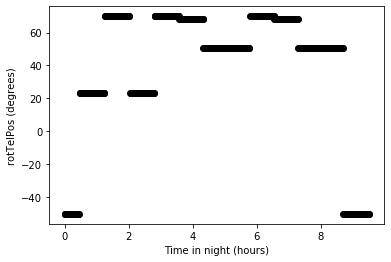

In [8]:
plt.plot(time, rotTelPos, 'ko')
plt.xlabel('Time in night (hours)')
plt.ylabel('rotTelPos (degrees)')

Text(0, 0.5, 'rotTelPos (degrees)')

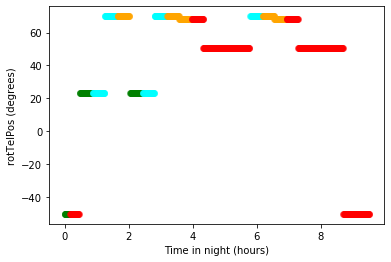

In [9]:
# Because it's fun to see what filter we're in
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
        'i': 'cyan', 'z': 'orange', 'y': 'red'}

for fn in f2c:
    in_filt = np.where(df['filter'].values == fn)[0]
    plt.plot(time[in_filt],
             rotTelPos[in_filt], 'o',
             color=f2c[fn], alpha=0.5)
plt.xlabel('Time in night (hours)')
plt.ylabel('rotTelPos (degrees)')

Note, the simulation records rotTelPos at the start of each exposure (95% sure it's the start), so those horozontal blocks are times when the camera tracks then rotates back, tracks rotates back, etc. 

Now this has revealed a potential inefficency in the scheduling algorithm. We've been planning on rotationally dithering by picking a rotTelPos value randomly for each night, and taking everything with that rotation. As we can see, that's not exactly happening. Turns out that the magic of random number generator seeds means each survey object (r+i, i+z, y+y, twilight, ddfs, etc) are picking their own rotTelPos values for the night. Consider those large changes in rotTelPos potentially temporary, they will probably disapear in the next version.

In [10]:
site = Site('LSST')

In [11]:
readtime = 2.+1.  # shutter close and read time
readtimes = (df['numExposures'] -1.)*readtime
visitTime = readtimes + df['visitExposureTime']

In [12]:
mjd_end = df['observationStartMJD'] + visitTime/3600./24.

In [13]:
alt_end, az_end = approx_RaDec2AltAz(df['fieldRA'].values, df['fieldDec'].values, site.latitude, site.longitude, mjd_end.values)
pa_end = approx_altaz2pa(alt_end, az_end, site.latitude)
rotTelPos_end = df['rotSkyPos'].values + pa_end
big = np.where(rotTelPos_end > 180.)[0]
rotTelPos_end[big] -= 360

Text(0, 0.5, '#')

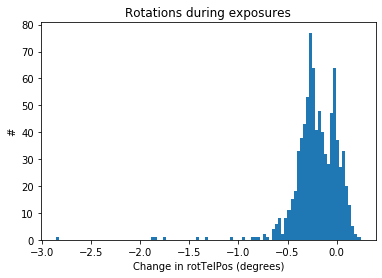

In [14]:
# Let's look at the distribution of delta rotator during exposures
delta_rtp = np.degrees(smallest_signed_angle(np.radians(rotTelPos), np.radians(rotTelPos_end))) 
_tmp = plt.hist(delta_rtp, bins=100)
plt.title('Rotations during exposures')
plt.xlabel('Change in rotTelPos (degrees)')
plt.ylabel('#')

Text(0, 0.5, '#')

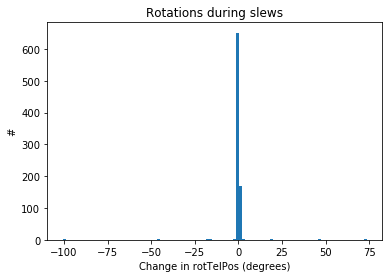

In [15]:
# Now between exposures
delta_rtp = np.degrees(smallest_signed_angle(np.radians(rotTelPos_end[0:-1]),
                                             np.radians(rotTelPos[1:])))
_tmp = plt.hist(delta_rtp, bins=100)
plt.title('Rotations during slews')
plt.xlabel('Change in rotTelPos (degrees)')
plt.ylabel('#')

Text(0, 0.5, '#')

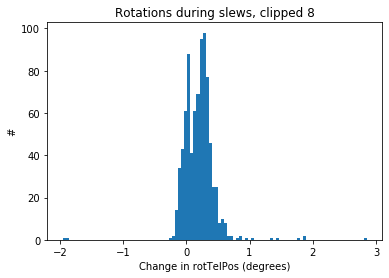

In [16]:
# Let's look at the distribution of delta rotator between exposures, clipping off the big ones
delta_rtp = np.degrees(smallest_signed_angle(np.radians(rotTelPos_end[0:-1]),
                                             np.radians(rotTelPos[1:])))
good = np.where(np.abs(delta_rtp) < 5.)[0]
_tmp = plt.hist(delta_rtp[good], bins=100)
plt.title('Rotations during slews, clipped %i' %(delta_rtp.size-good.size))
plt.xlabel('Change in rotTelPos (degrees)')
plt.ylabel('#')
